## VI. Organisation du code en programmation orienté objet

Pour analyser la sensibilité de la simulation par rapport aux paramètres (il y en a 6 que l'on veut faire varier), on va implémenter le modèle et les méthodes en programmation orienté objet.

Cela permet d'avoir un code plus facile à modifier, et les variables ne sont plus globales mais les méthodes de la classe peuvent quand même y accéder avec `self.variable`, ce qui limite le risque d'erreur avec les variables par rapport à des variables qui vivent dans le namespace global.
De plus, 

In [39]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import pandas as pd
import timeit

sns.set_theme()
rng = default_rng()


On va avoir besoin de cette fonction monte_carlo, mais on ne la met pas dans la classe de notre option Black&Scholes car elle est plus générale.


In [40]:
def monte_carlo(sample, proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba
    quantile_alpha = stats.norm.ppf(1 - alpha / 2)
    intervalle_size = quantile_alpha * np.sqrt(var / sample.size)
    return mean, var, mean - intervalle_size, mean + intervalle_size


On definit une classe BlackScholesOption qui prend en paramètres les variables du modèle. On recopie le code de nos méthodes de reduction de variance dans des méthodes de la classe.

On ne veut pas que un paramètre soit changé après une instanciation de la classe, par exemple changer `sigma` car `mat_L` ne correspondra plus. 

Pour cela, il faudrait rendre les variables de la classe immuable en mettant un getter `@property` mais pas de setter. 
Dans ce projet on ne le fera pas pour simplifier, mais c'est une bonne pratique surtout si d'autres personnes utilisent la classe : même en ayant codé moi meme la classe je suis tombé dans le piège de croire que je pouvais changer un paramètre comme `r` après l'instanciation.

In [41]:
class BlackScholesOption:
    # initalisation des paramètres
    def __init__(self, d=10, T=1, r=0.01, S0=100, sigma=None, rho=0.2, K=80):
        self.d, self.T, self.r, self.rho, self.K = d, T, r, rho, K
        # S0 peut être un float, un int ou un array
        if isinstance(S0, float) or isinstance(S0, int):
            self.title_S0 = S0
            self.S0 = np.full(d, S0)
        else:
            self.title_S0 = "custom"
            self.S0 = S0
        # sigma peut être un float, un int ou un array
        if sigma is None:
            self.title_sigma = "défaut"
            self.sigma = np.arange(1, d + 1) / (2 * d)
        elif isinstance(sigma, float) or isinstance(sigma, int):
            self.title_sigma = sigma
            self.sigma = np.full(d, sigma)
        else:
            self.title_sigma = "custom"
            self.sigma = sigma
        self.mu = r - 0.5 * self.sigma**2
        self.correl = np.full((d, d), rho) + (1 - rho) * np.eye(d)
        self.mat_L = np.linalg.cholesky(self.correl)

    def psi(self, sample_G):
        # Simulation d'un echantillon de taille n a partir d'un echantillon de n*d gaussiennes
        ST = self.S0[:, np.newaxis] * np.exp(
            self.mu[:, np.newaxis] * self.T + self.sigma[:, np.newaxis] * np.sqrt(self.T) * self.mat_L @ sample_G
        )
        return np.maximum(np.mean(ST, axis=0) - self.K, 0)

    def monte_carlo(self, sample_G, alpha=0.95):
        # Monte Carlo classique
        sample = self.psi(sample_G)
        return monte_carlo(sample, alpha)

    def monte_carlo_anth(self, sample_G, alpha=0.95):
        # Monte Carlo avec variable antithétique
        sample_va = 0.5 * (self.psi(sample_G) + self.psi(-sample_G))
        return monte_carlo(sample_va, alpha)

    def price_call_BS(self, x, r, sigma):
        # Calcul de la valeur exacte en dimension 1 avec la formule de Black-Scholes
        d1 = (np.log(x / self.K) + self.T * (r + 0.5 * sigma**2)) / (sigma * np.sqrt(self.T))
        d2 = d1 - sigma * np.sqrt(self.T)
        return x * stats.norm.cdf(d1) - self.K * np.exp(-r * self.T) * stats.norm.cdf(d2)

    def control_variable(self, sample_G):
        # Variable de contrôle
        barS0 = self.S0.mean()
        a = self.S0 / self.S0.sum()
        m = (a * (self.r - 0.5 * self.sigma**2)).sum()
        s2 = (((a * self.sigma).T @ self.mat_L) ** 2).sum()
        rho_controle = m + 0.5 * s2
        # Calcul de l'approximation par la formule fermee en dimension 1
        Y_mean = np.exp(rho_controle * self.T) * self.price_call_BS(barS0, rho_controle, sigma=np.sqrt(s2))
        Z = np.sum(
            a[:, np.newaxis] * (m * self.T + self.sigma[:, np.newaxis] * np.sqrt(self.T) * self.mat_L @ sample_G),
            axis=0,
        )
        Y = np.maximum(self.S0.mean() * np.exp(Z) - self.K, 0)
        return Y - Y_mean

    def monte_carlo_cv(self, sample_G, alpha=0.95):
        # Monte Carlo avec variable de contrôle
        control_variate = self.control_variable(sample_G)
        sample_controle = self.psi(sample_G) - control_variate
        return monte_carlo(sample_controle, alpha)

    def monte_carlo_cvo(self, sample_G, alpha=0.95):
        # Monte Carlo avec variable de contrôle optimale
        X = self.psi(sample_G)
        Y_centrée = self.control_variable(sample_G)
        Lambda = np.mean(X * Y_centrée) / np.mean(Y_centrée**2)
        sample_optimal = X - (Lambda * Y_centrée)
        return monte_carlo(sample_optimal, alpha)

    def monte_carlo_cvo_anth(self, sample_G, alpha=0.95):
        # Monte Carlo avec variable de contrôle optimale et variable antithétique
        X = self.psi(sample_G)
        Y_centrée = self.control_variable(sample_G)
        Lambda = np.mean(X * Y_centrée) / np.mean(Y_centrée**2)
        sample_optimal_anth = 0.5 * (
            (X - Lambda * Y_centrée) + (self.psi(-sample_G) - Lambda * self.control_variable(-sample_G))
        )
        return monte_carlo(sample_optimal_anth, alpha)

    def monte_carlo_ratio_variance(self, sample_G, alpha=0.95):
        # Monte Carlo avec toutes les méthodes, calcul du ratio de variance
        var_mc = self.monte_carlo(sample_G, alpha)[1]
        if var_mc == 0:
            return (0, 0, 0, 0)
        return (
            var_mc / self.monte_carlo_anth(sample_G, alpha)[1],
            var_mc / self.monte_carlo_cv(sample_G, alpha)[1],
            var_mc / self.monte_carlo_cvo(sample_G, alpha)[1],
            var_mc / self.monte_carlo_cvo_anth(sample_G, alpha)[1],
        )


On ajoute des méthodes à la classe `BlackScholesOption` pour obtenir la liste des paramètres de l'option, ce sera plus simple pour faire varier un seul paramètre sans devoir stocker dans une variable globale les paramètres qui ont étés utilisés à la création de l'option.

On veut aussi pouvoir mettre le nom de la methode de reduction de variance en argument, pour simplifier le code des comparaisons de méthode par la suite.

In [42]:
def get_params(self):
    # renvoie les paramètres
    return {
        "d": self.d,
        "K": self.K,
        "rho": self.rho,
        "T": self.T,
        "r": self.r,
        "S0": self.S0,
        "sigma": self.sigma,
    }


def get_params_title(self, param):
    # renvoie les paramètres imprimables sauf le parametre que l'on fait varier, pour les titres de graphiques
    params = {
        "d": self.d,
        "K": self.K,
        "rho": self.rho,
        "T": self.T,
        "r": self.r,
        "S0": self.title_S0,
        "sigma": self.title_sigma,
    }
    if param in params:
        del params[param]
    return params


def monte_carlo_method(self, sample_G, method="", alpha=0.95):
    # Monte Carlo avec toutes les méthodes
    if method == "":
        return self.monte_carlo(sample_G, alpha)
    elif method == "VA":
        return self.monte_carlo_anth(sample_G, alpha)
    elif method == "CV":
        return self.monte_carlo_cv(sample_G, alpha)
    elif method == "CVO":
        return self.monte_carlo_cvo(sample_G, alpha)
    elif method == "CVO+VA":
        return self.monte_carlo_cvo_anth(sample_G, alpha)
    else:
        raise ValueError("Méthode non reconnue")


setattr(BlackScholesOption, "get_params", get_params)
setattr(BlackScholesOption, "get_params_title", get_params_title)
setattr(BlackScholesOption, "monte_carlo_method", monte_carlo_method)


On veut visualiser l'influence des hyperparamètres sur la valeur de l'estimateur en prenant en compte son intervalle de confiance, sa variance, et le ratio de variance de la méthode de réduction de variance utilisée par rapport à la méthode de Monte Carlo classique.

Pour chaque paramètre, on le fait varier en fixant tous les autres pour déterminer quelle méthode réduit le plus la variance grace au ratio de variance, puis on plot la valeur et la variance de l'estimateur qui utilise cette méthode (c'est notre meilleur estimateur, pour une taille d'échantillon fixée).

On definit une fonction pour mettre les ratio de variance dans un dataframe et les visualiser avec la fonction plot des dataframe.


In [43]:
def generate_options(Option, param, lower, upper, nb):
    # Génération d'une liste d'options avec des paramètres différents
    index = np.linspace(lower, upper, nb).round(5)  # On arrondit pour éviter les problèmes d'arrondi
    params = Option.get_params()
    # Si on veut faire varier sigma, mais en gardant la progression arithmetique de 1/2d à 1/2, on multiplie par un facteur
    if param == "coeff de mult de sigma":
        sigmas = [(np.arange(1, Option.d + 1) * x) / (2 * Option.d) for x in index]
        v_params = [{**params, "sigma": sigma} for sigma in sigmas]
    else:
        v_params = [{**params, param: value} for value in index]
    Options = [BlackScholesOption(**params) for params in v_params]
    return Options, index


def compare_variance_ratio(Option, param, lower, upper, step_ratio, ax, sample_G, alpha=0.95):
    # Comparaison des ratios de variance pour différentes valeurs de param, param est une chaine de caractère
    Options, index = generate_options(Option, param, lower, upper, step_ratio)
    result = [Option.monte_carlo_ratio_variance(sample_G, alpha) for Option in Options]
    df = pd.DataFrame(result, columns=["VA", "CV", "CVO", "CVO+VA"], index=index)
    df.index.name = param
    df.plot(kind="bar", ax=ax, alpha=0.8, ylabel="Var ratio", xlabel=param, colormap="gist_rainbow")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)


def generate_mc_param(Option, param, lower, upper, step, sample_G, method="", alpha=0.95):
    # Comparaison des valeurs de l'estimateur MC+method pour différentes valeurs de param
    # method et param sont des chaines de caractères
    Options, index = generate_options(Option, param, lower, upper, step)
    result = [Option.monte_carlo_method(sample_G, method=method, alpha=alpha) for Option in Options]
    df = pd.DataFrame(result, columns=["mean", "var", "ci_lower", "ci_upper"], index=index)
    df.index.name = param
    return df


def plot_mc_param(Option, sample_G, param, lower, upper, step=100, step_ratio=10, method="", alpha=0.95):
    # On plot le dataframe retourné par generate_mc_param
    df = generate_mc_param(Option, param, lower, upper, step, sample_G, method, alpha)

    # plot des ratio de variance, du mean et de la variance
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), layout="constrained")
    compare_variance_ratio(Option, param, lower, upper, step_ratio, axs[0], sample_G, alpha)
    df.plot(y="mean", ax=axs[1], alpha=1, linewidth=0.5, color="red", ylabel="Mean+CI", sharex=True)
    axs[1].fill_between(df.index, df["ci_lower"], df["ci_upper"], alpha=0.3, color="royalblue")
    df.plot(y="var", ax=axs[2], color="indianred", ylabel="Variance")

    # Titre avec les parametres utilisés
    fig.suptitle(
        f"Monte Carlo {method} en faisant varier {param} de {lower} à {upper}\n{Option.get_params_title(param)}",
        fontsize=12,
    )
    plt.show()


On essaie cette nouvelle classe pour voir si les resultats sont cohérents. On commence par faire varier le paramètre du strike $K$, avec `T=50` pour avec des intervalles de confiance larges, une premiere fois avec la méthode de Monte-Carlo simple (MC) puis une fois avec la méthode de la variable optimale combinée avec la méthode de la variable antithétique (MC+CVO+ANTH).

À chaque fois qu'on fait varier un paramètre, les autres paramètres prennent la valeur par defaut definie dans la classe.


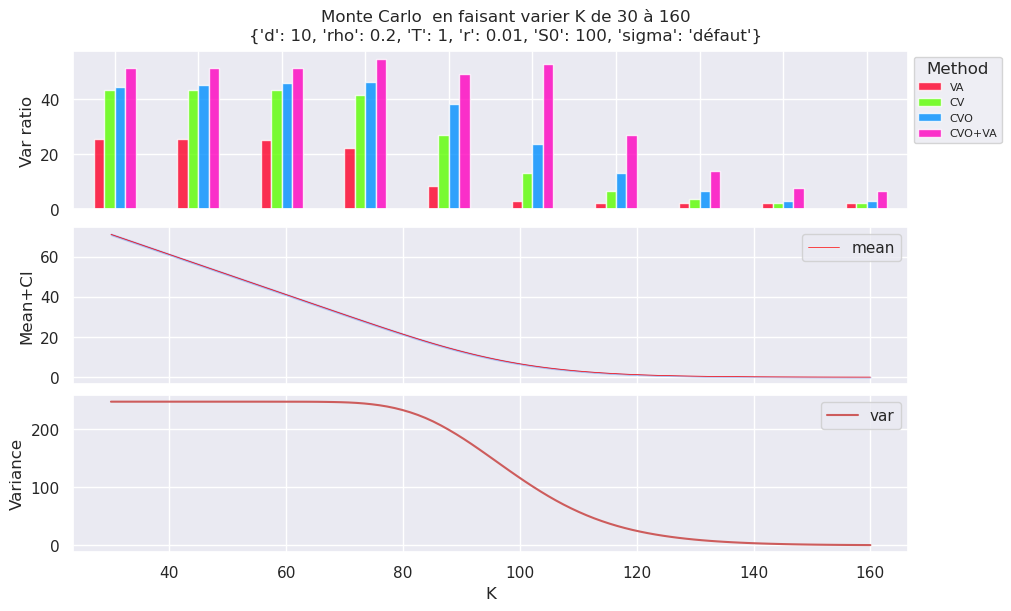

In [44]:
# Changer n en fonction de la machine pour le temps de calcul
n = int(1e4)
d = 10

sample_G = rng.standard_normal(size=(d, n))

# TEST
plot_mc_param(BlackScholesOption(), sample_G, "K", 30, 160, method="")

## VII. Influence des paramètres

$\textbf{2. Variation d'un paramètre, pour un échantillon fixé }$

In [45]:
# GOAL
Option = BlackScholesOption()
d = Option.d
sample_G = rng.standard_normal(size=(d, n))
plages = [
    # (Option, sample_G, "S0", 50, 150, 100, 11),
    # (Option, sample_G, "K", 50, 150, 100, 11),
    (Option, sample_G, "r", 0.01, 0.1, 100, 10),
    (Option, sample_G, "sigma", 0.01, 0.02, 100, 10),
    # (Option, sample_G, "sigma", 0.05, 0.15, 100, 10),
    (Option, sample_G, "sigma", 0.2, 0.6, 100, 10),
    (Option, sample_G, "coeff de mult de sigma", 0.5, 2, 100, 10),
    (Option, sample_G, "T", 0.2, 1, 100, 10),
    (Option, sample_G, "T", 5, 50, 100, 10),
    (Option, sample_G, "rho", 0.05, 0.2, 100, 10),
    (Option, sample_G, "rho", 0.5, 0.9, 100, 10)
]

# for plage in plages:
    # plot_mc_param(*plage, method="CVO+VA", alpha=0.95)


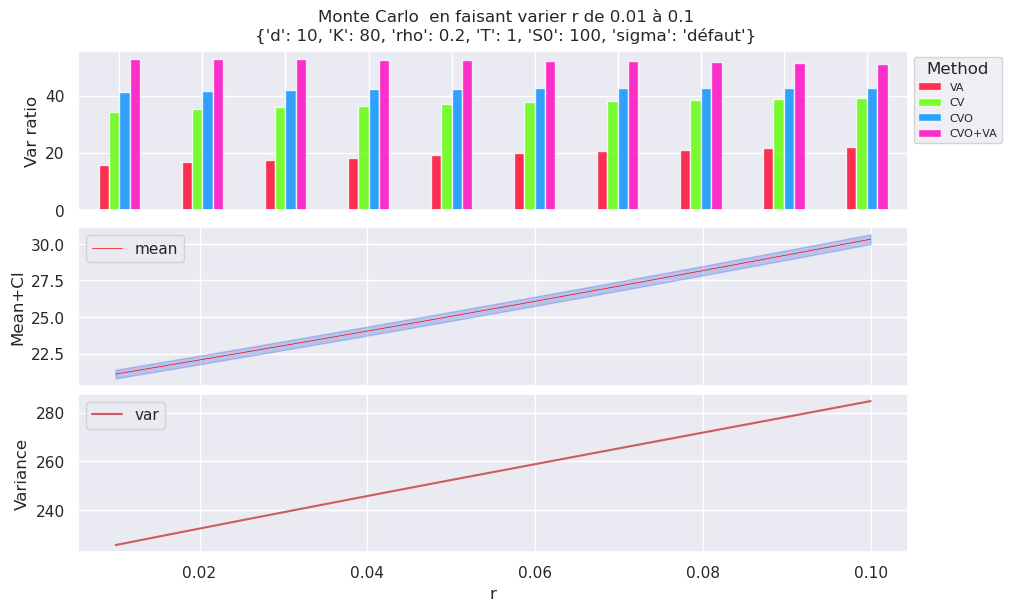

In [46]:
i = 0
plot_mc_param(*plages[i])

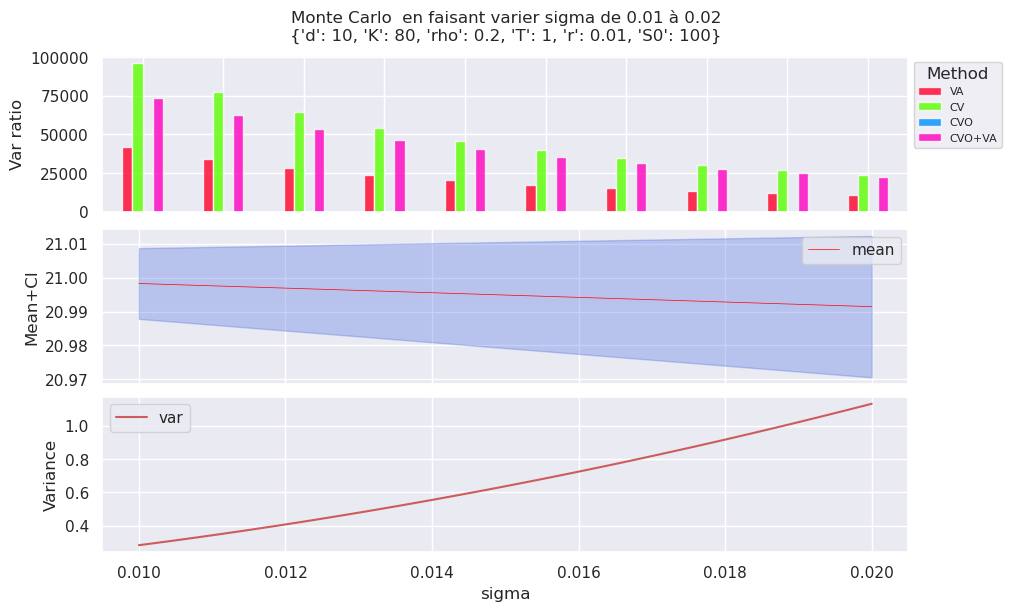

In [47]:
i += 1
plot_mc_param(*plages[i])

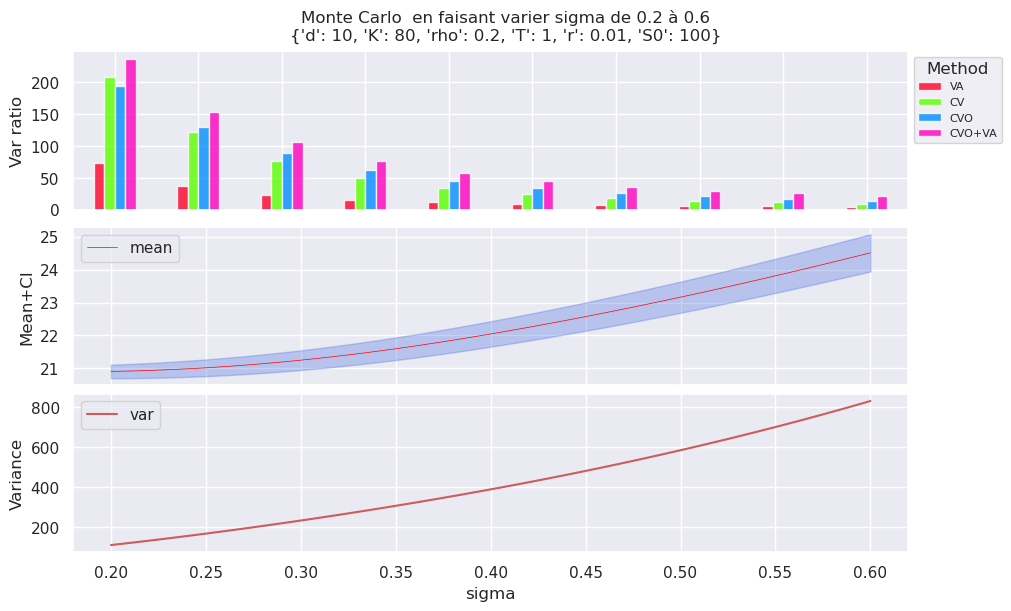

In [48]:
i += 1
plot_mc_param(*plages[i])

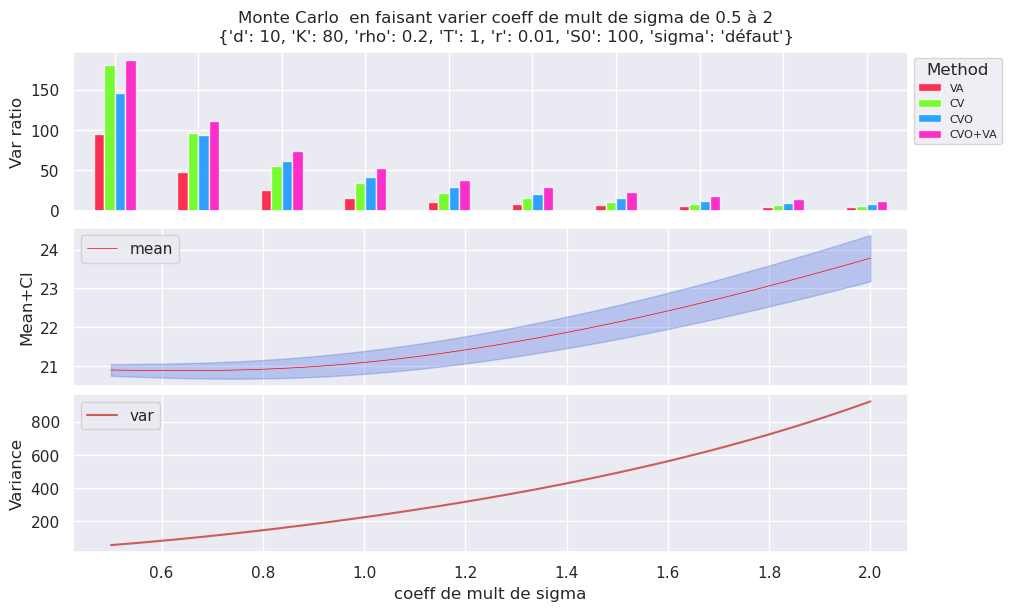

In [49]:
i += 1
plot_mc_param(*plages[i])

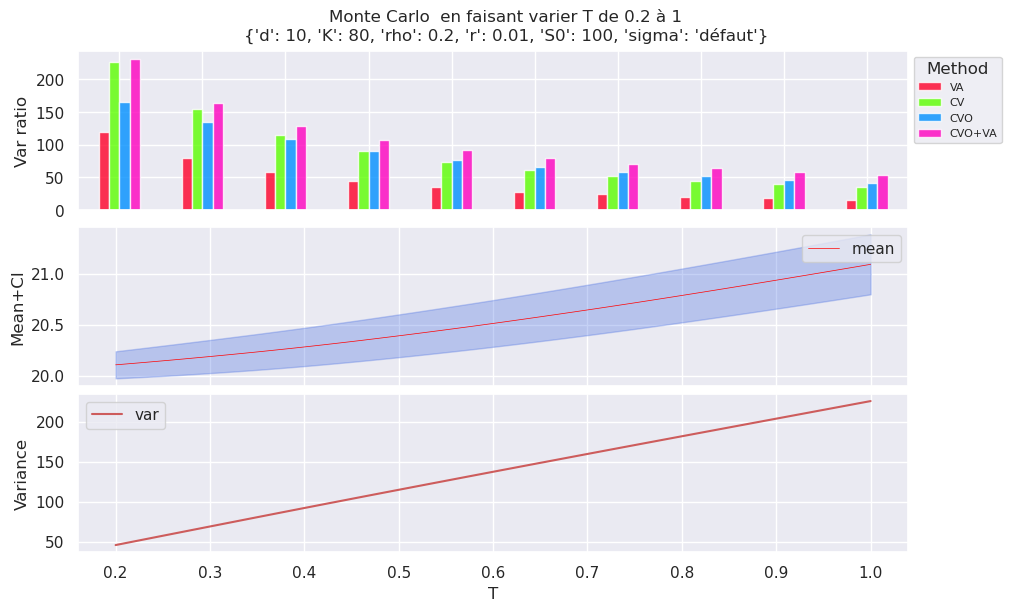

In [50]:
i += 1
plot_mc_param(*plages[i])

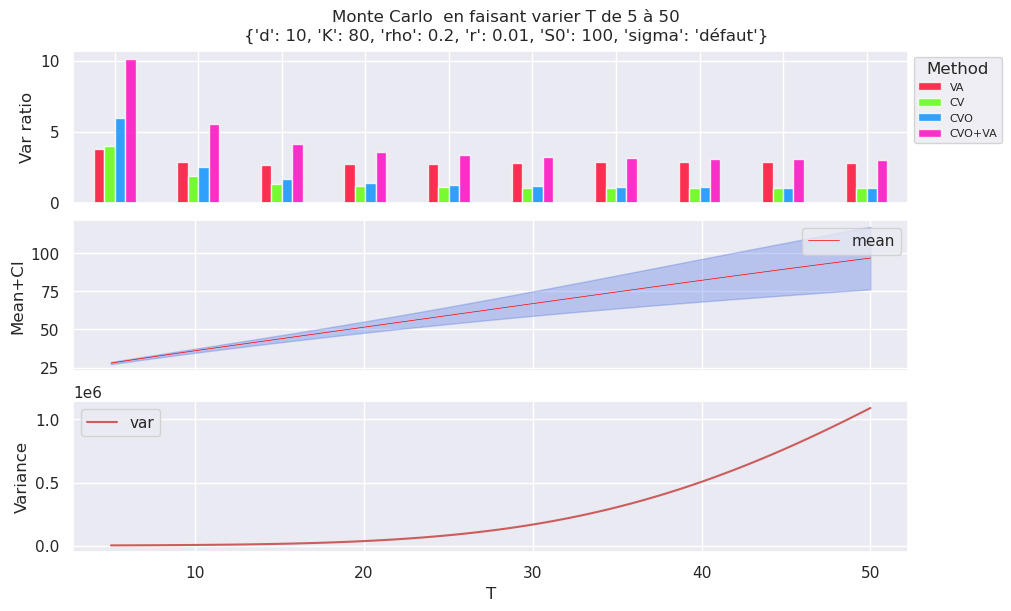

In [51]:
i += 1
plot_mc_param(*plages[i])

Ici la méthode de la variable de contrôle optimale a un ratio de de variance plus faible que la méthode des variables antithétiques. Pourtant, la méthode antithétique correspond à la variable de contrôle 
$$
Y = \frac{\psi(G) - \psi(-G)}{2} \quad \text{avec} \quad \mathbb{E}
$$

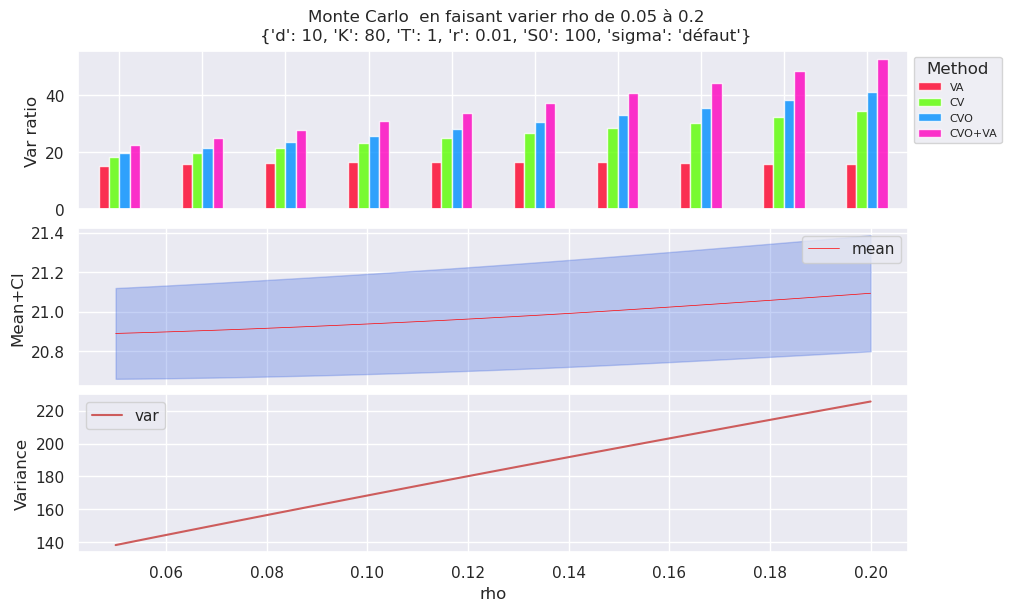

In [52]:
i += 1
plot_mc_param(*plages[i])

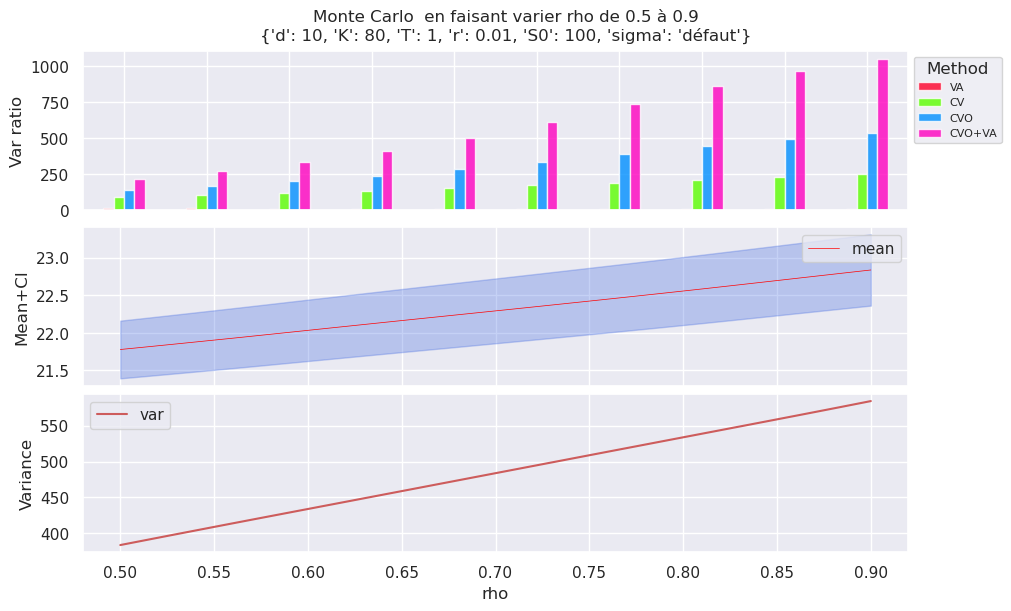

In [53]:
i += 1
plot_mc_param(*plages[i])

$\textbf{2. Influence de la taille de l'échantillon et de la dimension, temps d'éxécution }$

On ajoute une méthode à la classe pour comparer le temps d'exécution des différentes méthodes de réduction de variance par rapport au temps d'exécution de la méthode de Monte-Carlo classique.

On ajoute aussi une méthode qui crée des échantillons, on veut pouvoir passer une liste de `n` ou de `d` pas forcément à pas constant.


In [ ]:
def monte_carlo_time(self, sample_G, nb_rep=1000, alpha=0.95):
    # Monte Carlo avec toutes les méthodes, calcul du temps d'exécution
    time_mc = timeit.timeit(lambda: self.monte_carlo(sample_G, alpha=0.95), number=nb_rep)
    if time_mc == 0:
        return (0, 0, 0, 0)
    return (
        timeit.timeit(lambda: self.monte_carlo(sample_G, alpha=0.95), number=nb_rep),
        timeit.timeit(lambda: self.monte_carlo_anth(sample_G, alpha=0.95), number=nb_rep),
        timeit.timeit(lambda: self.monte_carlo_cv(sample_G, alpha=0.95), number=nb_rep),
        timeit.timeit(lambda: self.monte_carlo_cvo(sample_G, alpha=0.95), number=nb_rep),
        timeit.timeit(lambda: self.monte_carlo_cvo_anth(sample_G, alpha=0.95), number=nb_rep)
    )


setattr(BlackScholesOption, "monte_carlo_time", monte_carlo_time)

def generate_samples(self, param, list_param, n):
    # Génère les samples en fonction du paramètre
    if param == "d":
        return [rng.standard_normal(size=(d, n)) for d in list_param]
    elif param == "n":
        return [rng.standard_normal(size=(self.d, n)) for n in list_param]
    else:
        raise ValueError("Paramètre non reconnu")
    
setattr(BlackScholesOption, "generate_samples", generate_samples)


In [ ]:
def compare_time(Option, param, list_param, ax, nb_rep = 10, n=1000, alpha=0.95):
    # Compare le temps d'exécution des différentes méthodes
    samples = Option.generate_samples(param, list_param, n)
    if param == "d":
        list_option = [BlackScholesOption(d=d) for d in list_param]
        results = [option.monte_carlo_time(sample, nb_rep=nb_rep, alpha=alpha) for option, sample in zip(list_option, samples)]
    else:
        results = [Option.monte_carlo_ratio_time(sample, alpha=alpha) for sample in samples]
    df = pd.DataFrame(results, columns=["MC", "VA", "CV", "CVO", "CVO+ANTH"], index=list_param)
    df.index.name = param
    df.plot(kind='line', logx=True, alpha=0.8, ylabel="Time ratio", xlabel=param, ax=ax)
    ax.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

In [ ]:
#TEST
N = [int(10**i) for i in range(3, 8)]
D = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Option = BlackScholesOption()
fig, ax = plt.subplots()
# compare_time(Option, "n", N, ax)
compare_time(Option, "d", D, ax)

In [ ]:
#TEST
N = [int(10**i) for i in range(3, 8)]
D = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Option = BlackScholesOption()
fig, ax = plt.subplots()
# compare_time(Option, "n", N, ax)
compare_time(Option, "d", D, ax)

## Interprétation ??

# Calcul de sensibilité

On va suivre ici la méthode du calcul de sensibilités du TP4, en l'appliquant à notre modèle.
On cherche à calculer la dérivée de l'estimation du prix de l'option par rapport à un paramètre $\lambda$:
\begin{equation*}
    \frac{\partial}{\partial \lambda} I_{n}(\lambda)
\end{equation*}
où $I_n(\lambda)$ est notre estimateur du prix de l'option en un paramètre $\lambda$.

- Le premier estimateur naïf $J^{(1)}_{n,h}(\lambda)$ est basé sur des réalisations indépendantes de $I_n(\lambda+h)$ et $I_n(\lambda-h)$
\begin{equation*}
    J^{(1)}_{n,h}(\lambda, h) = \frac{I_{n}(\lambda+h) - \tilde I_{n}(\lambda-h)}{2 h}
\end{equation*}
où $I_n(\lambda+h)$ et $\tilde I_n(\lambda-h)$ sont des réalisations de notre estimateur sur des échantillons `sample_G1` et `sample_G2` indépendants.
- Le deuxième estimateur $J^{(2)}_{n,h}(\lambda)$ utilise des réalisations fortements corrélées de la loi log-normale au sens suivant: on utilise le même échantillon `sample_G` pour construire deux réalisations $I_n(\lambda+h)$ et $I_n(\lambda-h)$ :
\begin{equation*}
    J^{(2)}_{n,h}(\lambda, h) = \frac{I_n(\lambda+h) - \bar I_n(\lambda-h) }{2 h} ,
\end{equation*}
où $I_n(\lambda+h)$ et $I_n(\lambda-h)$ sont des réalisations de notre estimateur sur le même échaniillon `sample_G`.


In [ ]:
def J1(self, sample_G1, sample_G2, param, lambda_, h, alpha=0.95):
    # Calcul de la dérivée de la fonction de coût par rapport à un paramètre
    # param est une chaine de caractère
    params1 = self.get_params()
    params1[param] = lambda_ + h
    Option1 = BlackScholesOption(**params1)
    params2 = self.get_params()
    params2[param] = lambda_ - h
    Option2 = BlackScholesOption(**params2)
    res = monte_carlo((Option1.psi(sample_G1) - Option2.psi(sample_G2)) / (2 * h), alpha)
    return res[0], res[1]


setattr(BlackScholesOption, "J1", J1)


def J2(self, sample_G, param, lambda_, h, alpha=0.95):
    # Calcul de la dérivée de la fonction de coût par rapport à un paramètre, avec un seul sample
    return self.J1(sample_G, sample_G, param, lambda_, h, alpha)


setattr(BlackScholesOption, "J2", J2)


On commence par calculer les estimateurs $J^{(1)}_{n,h}(\lambda, h)$ et $J^{(2)}_{n,h}(\lambda, h)$ pour un échantillon de taille $n=10^5$ et une dimension $d=10$, et les paramètres de l'option par défaut.

In [ ]:
Option = BlackScholesOption()
d = Option.d
n = int(1e5)

sample_G1 = rng.standard_normal(size=(d, n))
sample_G2 = rng.standard_normal(size=(d, n))
H_s = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
J1_s = [Option.J1(sample_G1, sample_G2, "K", 100, h, alpha=0.95) for h in H_s]
J2_s = [Option.J2(sample_G1, "K", 100, h, alpha=0.95) for h in H_s]

df1 = pd.DataFrame(J1_s, columns=["mean", "var"], index=H_s)
print(df1)

df2 = pd.DataFrame(J2_s, columns=["mean", "var"], index=H_s)
print(df2)


La variance de `J1` explose quand h tend vers 0 : elle est mutltipliée par 100 à chaque division par 10 de `h`.

Sa valeur moyenne ne se stabilise pas non plus, elle grandit de la même facon que h diminue (x10 par step).
Cela n'est pas etonnant étant donné sa variance élevée, si on relance la cellule et que le sample change on obtient des valeurs differentes de `mean`, de l'ordre de grandeur de la racine de la variance `var`.

Dans la suite, on choisira donc l'estimateur `J2` pour l'estimation des sensibilités. 

On va aussi utiliser la meilleure méthode de réduction de variance qu'on a trouvé avant, c'est à dire CVO+VA.

Maintenant qu'on a choisi notre estimateur de la sensibilité, on s'intéresse seulement à sa valeur moyenne et non plus à sa variance.

Pour `h`, on prendra par defaut $\frac{1}{10^4}$ pour avoir une bonne précision.

In [ ]:
def J2_cvo_anth(self, sample_G, param, lambda_, h=1e-4, alpha=0.95):
    # Calcul de la dérivée de la fonction de coût par rapport à un paramètre
    params1 = self.get_params()
    params1[param] = lambda_ + h
    Option1 = BlackScholesOption(**params1)
    params2 = self.get_params()
    params2[param] = lambda_ - h
    Option2 = BlackScholesOption(**params2)
    res1 = Option1.monte_carlo_cvo_anth(sample_G, alpha=alpha)
    res2 = Option2.monte_carlo_cvo_anth(sample_G, alpha=alpha)
    return (res1[0] - res2[0]) / (2 * h), (res1[1] - res2[1]) / (2 * h)


setattr(BlackScholesOption, "J2_cvo_anth", J2_cvo_anth)


def plot_J2_cvo_anth(Option, sample_G, param, lower, upper, step=100, h=1e-4, alpha=0.95):
    # Trace la dérivée de la fonction de coût par rapport à un paramètre
    Options, index = generate_options(Option, param, lower, upper, step)
    results = [option.J2_cvo_anth(sample_G, param, lambda_, h, alpha=alpha) for option, lambda_ in zip(Options, index)]
    df = pd.DataFrame(results, columns=["mean", "var"], index=index)
    df.index.name = param

    # On plot le dataframe
    fig, ax = plt.subplots(2, 1, figsize=(8, 4), layout="constrained")
    df.plot(y="mean", ax=ax[0], alpha=0.8, color="blue", ylabel="sensi mean", sharex=True)
    ymin, ymax = ax[0].get_ylim()
    ax[0].set_ylim([min(ymin,0), max(ymax,0)])
    df.plot(y="var", ax=ax[1], alpha=0.8, color="indianred", ylabel="sensi var")
    ymin, ymax = ax[1].get_ylim()
    ax[1].set_ylim([min(ymin,0), max(ymax,0)])


setattr(BlackScholesOption, "plot_J2_cvo_anth", plot_J2_cvo_anth)


On fait quelques test pour vérifier que la dérivée est correcte :


In [ ]:
#TEST
Option = BlackScholesOption()
d = Option.d
n = int(1e5)

sample_G = rng.standard_normal(size=(d, n))
H_s = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
J2_s = [Option.J2_cvo_anth(sample_G, "K", 100, h, alpha=0.95) for h in H_s]

df = pd.DataFrame(J2_s, columns=["mean", "var"], index=H_s)
print(df)


On trouve les mêmes valeurs de J2 que avec la methode de Monte-Carlo classique, ce qui est rassurant.

In [ ]:
#TEST 
Option = BlackScholesOption()
d = Option.d
n = int(1e5)
sample_G = rng.standard_normal(size=(d, n))

plot_J2_cvo_anth(Option, sample_G, "K", 30, 160)


On reprend les plages de paramètres de la partie précédente.

In [ ]:
# GOAL
for plage in plages:
    plot_J2_cvo_anth(BlackScholesOption(*plage[0]), sample_G, *plage[1:-1], alpha=0.95)
